In [2]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

<b>Exploratory Data Analysis

In [35]:
#Import pbp data
seasons = range(2017, 2024)
pbp = nfl.import_pbp_data(seasons)

2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [36]:
#Filter pbp data to include only running plays
pbp_run = pbp.query("play_type == 'run' & rusher_id.notnull() & down.notnull() & run_location.notnull()").reset_index()

In [37]:
#Replace missing rushing yard values with 0
pbp_run.loc[pbp_run['rushing_yards'].isnull(), 'rushing_yards'] = 0

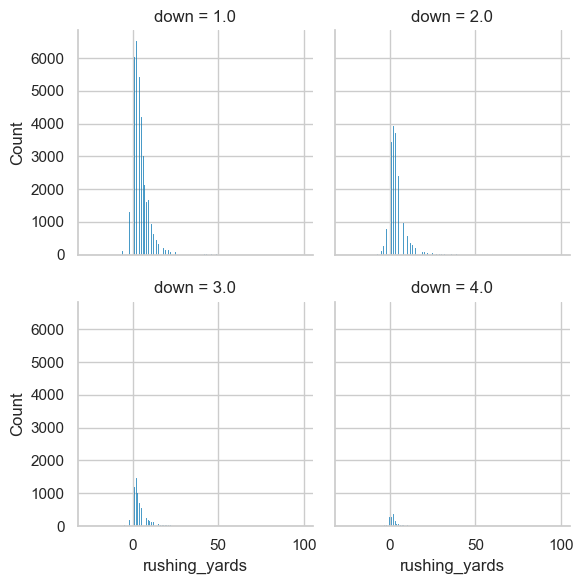

In [7]:
#Create a histogram for down and rushing yards gained
sns.set_theme(style = 'whitegrid', palette='colorblind')

#Change down to a string
pbp_run['down'].astype(str)

#Plot rushing yards by down
hist = sns.FacetGrid(data=pbp_run, col='down', col_wrap=2);

hist.map_dataframe(sns.histplot, x='rushing_yards');

plt.show();

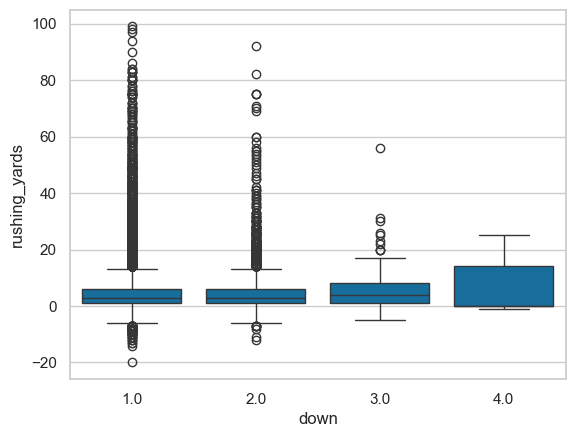

In [9]:
#Create a boxplot, but this time limit data to plays where ydstogo = 10
sns.boxplot(data=pbp_run.query("ydstogo == 10"), x='down', y='rushing_yards');

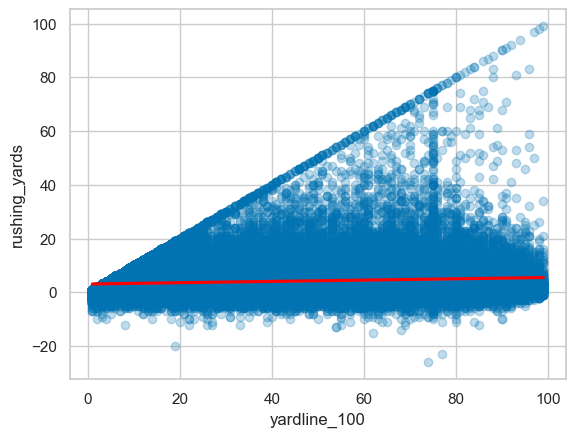

In [10]:
#Use a regression plot to look for a correlation between yards until endzone and yards gained
sns.regplot(data=pbp_run, x='yardline_100', y='rushing_yards', scatter_kws={'alpha': 0.25}, line_kws={'color': 'red'});

plt.show();

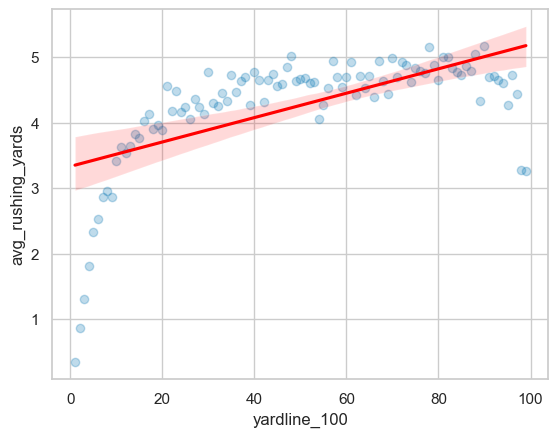

In [28]:
#Create a similar plot, but this time group avg rushing yards by yards to go until endzone
pbp_run_y100 = pbp_run.groupby('yardline_100').agg({'rushing_yards': 'mean'})

pbp_run_y100 = pbp_run_y100.rename(columns={'rushing_yards': 'avg_rushing_yards'})

pbp_run_y100.reset_index(inplace=True)

sns.regplot(data=pbp_run_y100, 
            x='yardline_100', 
            y='avg_rushing_yards', 
            scatter_kws={'alpha': 0.25}, 
            line_kws={'color': 'red'});

plt.show();

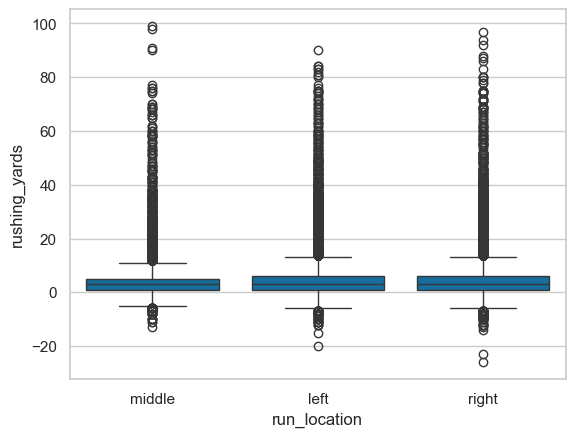

In [29]:
#Create a boxplot to show the results of rushing yards by run location
sns.boxplot(data=pbp_run, x='run_location', y='rushing_yards');

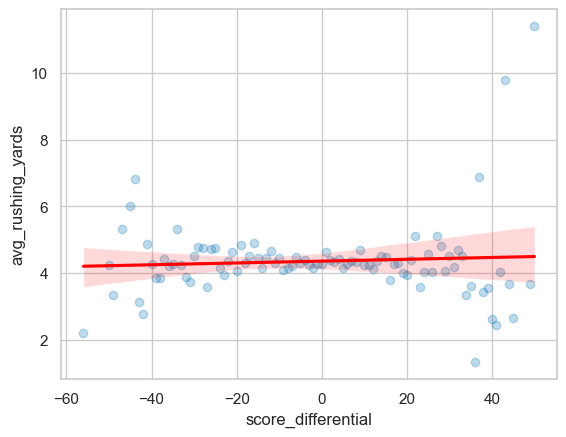

In [38]:
#Group average rushing yards by score differential and then plot the regression
pbp_run_sd = pbp_run.groupby('score_differential').agg({'rushing_yards': 'mean'})

pbp_run_sd = pbp_run_sd.rename(columns={'rushing_yards': 'avg_rushing_yards'})

pbp_run_sd.reset_index(inplace=True)

sns.regplot(data=pbp_run_sd,
            x='score_differential',
            y='avg_rushing_yards',
            scatter_kws={'alpha': 0.25},
            line_kws={'color': 'red'});

plt.show();

<b>Multiple Linear Regression

In [43]:
#Convert 'down' to a string data type
pbp_run['down'] = pbp_run['down'].astype(str)

In [46]:
#Fit the Multiple Linear Regression model
expected_yards = smf.ols(data=pbp_run,
                         formula='rushing_yards ~ 1 + down + ydstogo + down:ydstogo + ' +
                         'yardline_100 + run_location + score_differential')\
                    .fit()

In [47]:
#Use the residuals to create a new column for RYOE
pbp_run['ryoe'] = expected_yards.resid

In [49]:
#Examine the summary of the Multiple Linear Regression model
print(expected_yards.summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     140.9
Date:                Wed, 19 Jun 2024   Prob (F-statistic):          3.46e-323
Time:                        20:37:56   Log-Likelihood:            -2.9985e+05
No. Observations:               92374   AIC:                         5.997e+05
Df Residuals:                   92362   BIC:                         5.998e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

<b>RYOE Analysis

In [55]:
#Group RYOE data by player and season
ryoe_df = pbp_run.groupby(['season', 'rusher_id', 'rusher'])\
          .agg({'ryoe': ['count', 'sum', 'mean'],
               'rushing_yards': ['mean']})

ryoe_df.columns = list(map('_'.join, ryoe_df.columns))

ryoe_df.reset_index(inplace=True)

In [58]:
#Rename the columns and filter on players with >50 rush attempts
ryoe_df = ryoe_df.rename(columns={'ryoe_count': 'n', 
                        'ryoe_sum': 'ryoe_total', 
                        'ryoe_mean': 'ryoe_per', 
                        'rushing_yards_mean': 'yards_per_carry'})\
                .query('n > 50')

In [60]:
ryoe_df.sort_values(by='ryoe_per', ascending=False).head(10)

,season,rusher_id,rusher,n,ryoe_total,ryoe_per,yards_per_carry
1797,2022,00-0034796,L.Jackson,72,281.625973,3.911472,7.930556
2318,2023,00-0039040,D.Achane,109,337.174365,3.093343,7.422018
877,2019,00-0034796,L.Jackson,126,329.517079,2.615215,6.880952
904,2019,00-0035228,K.Murray,53,137.961772,2.603052,6.867925
1933,2022,00-0036945,J.Fields,77,178.833389,2.322512,6.506494
1161,2020,00-0034796,L.Jackson,118,258.639088,2.191857,6.415254
43,2017,00-0027939,C.Newton,92,192.100757,2.088052,6.173913
1192,2020,00-0035228,K.Murray,70,144.952657,2.070752,6.057143
1479,2021,00-0034750,R.Penny,119,240.198791,2.018477,6.294118
855,2019,00-0034400,J.Wilkins,51,97.345762,1.908740,6.019608


<b>Predictability of RYOE

In [61]:
#Create a list of columns to keep
cols_keep = ['season', 'rusher_id', 'rusher', 'ryoe_per', 'yards_per_carry']

In [62]:
#Create current dataframe
ryoe_now = ryoe_df[cols_keep].copy()

In [63]:
#Create last year's dataframe
ryoe_last = ryoe_df[cols_keep].copy()

In [66]:
#Rename columns
ryoe_last.rename(columns={'ryoe_per': 'ryoe_per_last', 'yards_per_carry': 'yards_per_carry_last'}, inplace=True)

In [67]:
#Add 1 to season
ryoe_last['season'] += 1

In [68]:
#Merge the current year and last year dataframe together
ryoe_lag = ryoe_now.merge(
            ryoe_last, 
            how='inner', 
            on=['rusher_id', 'rusher', 'season'])

In [69]:
#Examine the correlation for yards per carry
ryoe_lag[['yards_per_carry_last', 'yards_per_carry']].corr()

,yards_per_carry_last,yards_per_carry
yards_per_carry_last,1.00000,0.38109
yards_per_carry,0.38109,1.00000


In [70]:
#Examine the correlation for RYOE
ryoe_lag[['ryoe_per_last', 'ryoe_per']].corr()

,ryoe_per_last,ryoe_per
ryoe_per_last,1.000000,0.413521
ryoe_per,0.413521,1.000000


For players with over 50 rushing attempts from the 2017-2023 season, RYOE is a more stable year-over-year statistic than normal yards per carry.